In [5]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch 
import torch.nn as nn
import yfinance as yf
import keras 
import os
import tensorflow
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
def TickerIntoTensor(ticker='aapl',daysago=100,daysforward=1,split_percentage=0.9):
    df = yf.Ticker(ticker.upper())
    df = df.history(period='max')
    if df.shape[1] == 7:
        df = df.drop(columns=['Dividends','Stock Splits'])
    df = df.drop(columns=['Open','High','Low','Volume'])
    for i in range(daysago,-daysforward-1,-1):
        df['{}daysago'.format(i)] = df['Close'].shift(i)
        df = df.copy()
    df = df.drop(columns=['Close'])
    df = df.drop(index=df.tail(daysforward).index)
    df = df.drop(index=df.head(daysago).index)
    sc = MinMaxScaler(feature_range=(0,1))
    df_scaled = sc.fit_transform(df)
    X,Y = df_scaled[:,:daysago+1],df_scaled[:,-daysforward:]
    if split_percentage <= 1 and split_percentage >= 0:
        split = int(len(X)*split_percentage)
    else:
        split = split_percentage
    X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
    X_train, X_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1))
    if daysforward == 1:
        Y_train, Y_test = Y_train.reshape((-1,1)), Y_test.reshape((-1,1))
    else:
        Y_train, Y_test = Y_train.reshape((-1,daysforward)), Y_test.reshape((-1,daysforward))
    return X_train, X_test, Y_train, Y_test
TickerIntoTensor()

(array([[[3.09577038e-04],
         [2.83417248e-04],
         [2.48533656e-04],
         ...,
         [2.72269635e-04],
         [2.56185156e-04],
         [2.60537260e-04]],
 
        [[2.83417248e-04],
         [2.48533656e-04],
         [2.59433553e-04],
         ...,
         [2.60346312e-04],
         [2.62051514e-04],
         [2.64425612e-04]],
 
        [[2.48533656e-04],
         [2.59433553e-04],
         [2.72517314e-04],
         ...,
         [2.66307956e-04],
         [2.65962465e-04],
         [2.54704800e-04]],
 
        ...,
 
        [[2.78138592e-01],
         [2.81889999e-01],
         [2.89392909e-01],
         ...,
         [3.35563908e-01],
         [3.19708046e-01],
         [3.32612417e-01]],
 
        [[2.81889999e-01],
         [2.89392909e-01],
         [2.88976047e-01],
         ...,
         [3.24900990e-01],
         [3.34545575e-01],
         [3.21817878e-01]],
 
        [[2.89392909e-01],
         [2.88976047e-01],
         [2.88301824e-01],
         

In [20]:
sp500list = pd.read_csv("SP500.csv")
for i in sp500list['Symbol']:
    e = yf.Ticker(i)
    df = e.history(period='max')
    print(df)
    print(i)

                                 Open        High         Low       Close  \
Date                                                                        
1962-01-02 00:00:00-05:00    0.000000    0.587004    0.569739    0.574055   
1962-01-03 00:00:00-05:00    0.000000    0.578371    0.564344    0.578371   
1962-01-04 00:00:00-05:00    0.000000    0.588083    0.578371    0.578371   
1962-01-05 00:00:00-05:00    0.000000    0.576213    0.561106    0.563264   
1962-01-08 00:00:00-05:00    0.000000    0.564344    0.556790    0.560027   
...                               ...         ...         ...         ...   
2024-07-01 00:00:00-04:00  102.860001  103.449997  100.209999  100.610001   
2024-07-02 00:00:00-04:00  100.559998  101.930000  100.459999  101.620003   
2024-07-03 00:00:00-04:00  101.290001  102.150002  100.680000  101.620003   
2024-07-05 00:00:00-04:00  101.400002  101.660004  100.639999  101.320000   
2024-07-08 00:00:00-04:00  101.510002  102.739998  100.620003  101.099998   

$BRK.B: possibly delisted; No timezone found


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
BRK.B
                                Open       High        Low      Close  \
Date                                                                    
1985-04-18 00:00:00-05:00   0.000000   0.100775   0.098943   0.098943   
1985-04-19 00:00:00-05:00   0.099859   0.100775   0.099859   0.099859   
1985-04-22 00:00:00-05:00   0.098943   0.098943   0.098943   0.098943   
1985-04-23 00:00:00-05:00   0.098943   0.098943   0.097110   0.097110   
1985-04-24 00:00:00-05:00   0.097110   0.098026   0.097110   0.097110   
...                              ...        ...        ...        ...   
2024-07-01 00:00:00-04:00  84.320000  84.650002  82.150002  82.290001   
2024-07-02 00:00:00-04:00  81.550003  82.209999  80.529999  82.169998   
2024-07-03 00:00:00-04:00  82.900002  83.739998  82.209999  82.330002   
2024-07-05 00:00:00-04:00  82.300003  82.779999  81.629997  82.449997   
2024-07-08 00:00:00-04:00  83.019997  8

$BF.B: possibly delisted; No price data found  (1d 1925-08-01 -> 2024-07-08)


                                Open       High        Low      Close  \
Date                                                                    
1981-02-11 00:00:00-05:00   0.000000   0.108182   0.096162   0.096162   
1981-02-12 00:00:00-05:00   0.096162   0.096162   0.096162   0.096162   
1981-02-13 00:00:00-05:00   0.096162   0.096162   0.096162   0.096162   
1981-02-17 00:00:00-05:00   0.096162   0.096162   0.096162   0.096162   
1981-02-18 00:00:00-05:00   0.000000   0.108182   0.096162   0.096162   
...                              ...        ...        ...        ...   
2024-07-01 00:00:00-04:00  89.820000  90.099998  88.610001  89.110001   
2024-07-02 00:00:00-04:00  88.550003  89.680000  88.309998  89.650002   
2024-07-03 00:00:00-04:00  89.599998  90.309998  88.940002  90.040001   
2024-07-05 00:00:00-04:00  90.129997  90.610001  89.250000  90.519997   
2024-07-08 00:00:00-04:00  91.000000  91.360001  90.529999  90.570000   

                            Volume  Dividends  Sto

In [3]:

import DataPrep as ddd
daysago = 200
daysforward = 1




sp500list = pd.read_csv("SP500.csv")
ListOfTickers = []
for i in sp500list['Symbol']:
    ListOfTickers.append(i)

ListOfTickers.remove('BRK.B')
ListOfTickers.remove('BF.B')
ListOfTickers.remove('GEV')
ListOfTickers.remove('SOLV')
ListOfTickers.remove('HUBB')




sp500shits = ddd.TickerIntoTensor('^gspc', daysago, daysforward,0.9999,10)
X_train, sp500_X_test, Y_train, sp500_Y_test = sp500shits[0], sp500shits[1], sp500shits[2], sp500shits[3]

# print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


model1 = Sequential()
model1.add(InputLayer((X_train.shape[1], 1)))
model1.add(LSTM(X_train.shape[1]*daysforward))
model1.add(Dense(X_train.shape[1], 'sigmoid'))
model1.add(Dense(daysforward, 'linear'))

cp1 = ModelCheckpoint('model/.keras', save_best_only=False)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

for ticker in ListOfTickers:
    e = ddd.TickerIntoTensor(ticker, daysago, daysforward,0.9999,10)
    X_train= e[0]
    sp500_X_test = np.concatenate((sp500_X_test,e[1]))
    Y_train= e[2]
    sp500_Y_test = np.concatenate((sp500_Y_test,e[3]))
    
    print(ticker)
    model1.fit(X_train, Y_train, epochs=2, batch_size=2000, callbacks=[cp1])
# model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=2, batch_size=128, callbacks=[cp1])

MMM
Epoch 1/2
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - loss: 1.4286 - root_mean_squared_error: 1.1809
Epoch 2/2
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.6037 - root_mean_squared_error: 0.7649
AOS
Epoch 1/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.0904 - root_mean_squared_error: 0.2974
Epoch 2/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 0.0593 - root_mean_squared_error: 0.2425
ABT
Epoch 1/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0307 - root_mean_squared_error: 0.1748
Epoch 2/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 0.0117 - root_mean_squared_error: 0.1067
ABBV
Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0028 - root_mean_squared_error: 0.0515
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0122 - root_mean_squared_error: 0.1106
ACN
Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.0070 - root_mean_squared_error: 0.0832
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 0.0063 - root_mean_squared_error: 0.0792
ADBE
Epoch 1/2
5/5 ━━━━

$REG: possibly delisted; No price data found  (1d 1925-08-02 -> 2024-07-09)


ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required by MinMaxScaler.

In [11]:
from tensorflow.keras.models import load_model
import DataPrep as ddd
daysago = 200
daysforward = 1

model1 = load_model('model/4thstockpredictmodel.keras')
y_pred = model1.predict(ddd.TickerIntoTensor('nvda',daysago,daysforward,0.0001,20)[1])
Y_test = ddd.TickerIntoTensor('nvda',daysago,daysforward,0.0001,20)[3].reshape(-1,daysforward)
avg_error = (np.sum(np.sqrt((Y_test - y_pred)**2)))/len(Y_test)*100

print(avg_error)
avg_error = (np.sum(y_pred - Y_test))/len(Y_test)*100
print(avg_error)

194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step
0.28098758718275646
-0.22012125424411896


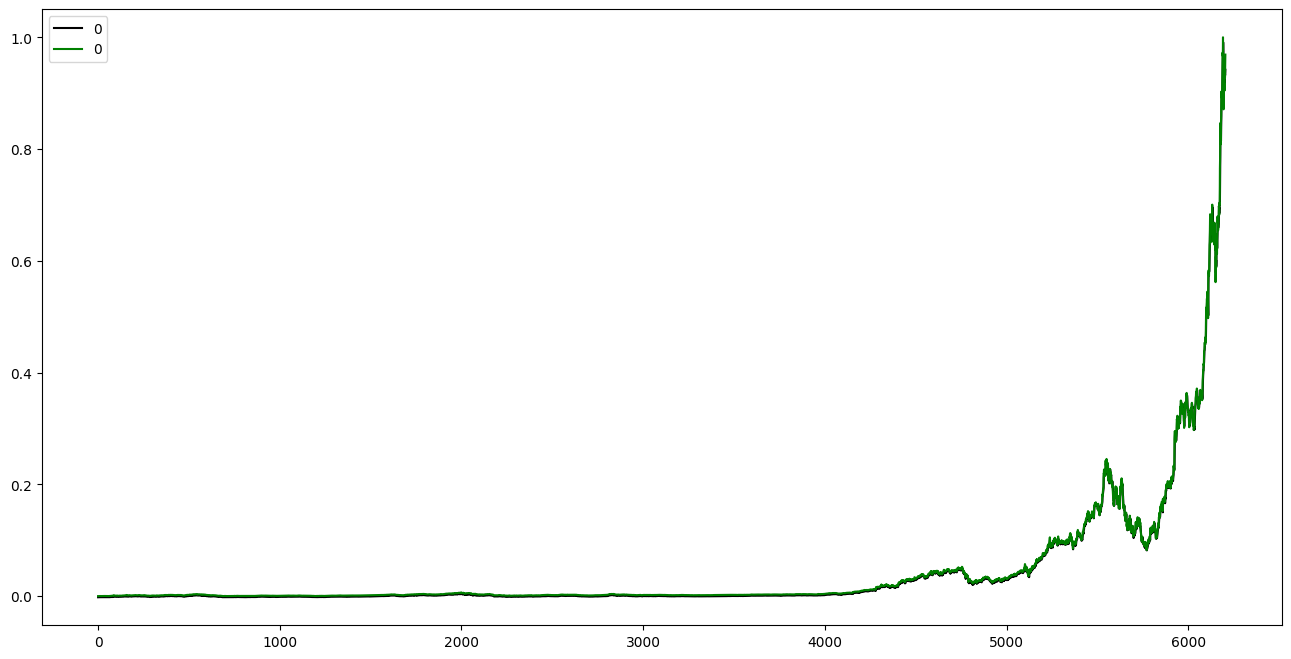

In [12]:
y_pred,Y_test = pd.DataFrame(y_pred),pd.DataFrame(Y_test)
for i in range(0,y_pred.shape[1]): 
    oneday= pd.concat([y_pred[i],Y_test[i]],axis=1)
    oneday.plot(figsize=(16,8),color = ('black','green'))
    

<Axes: >

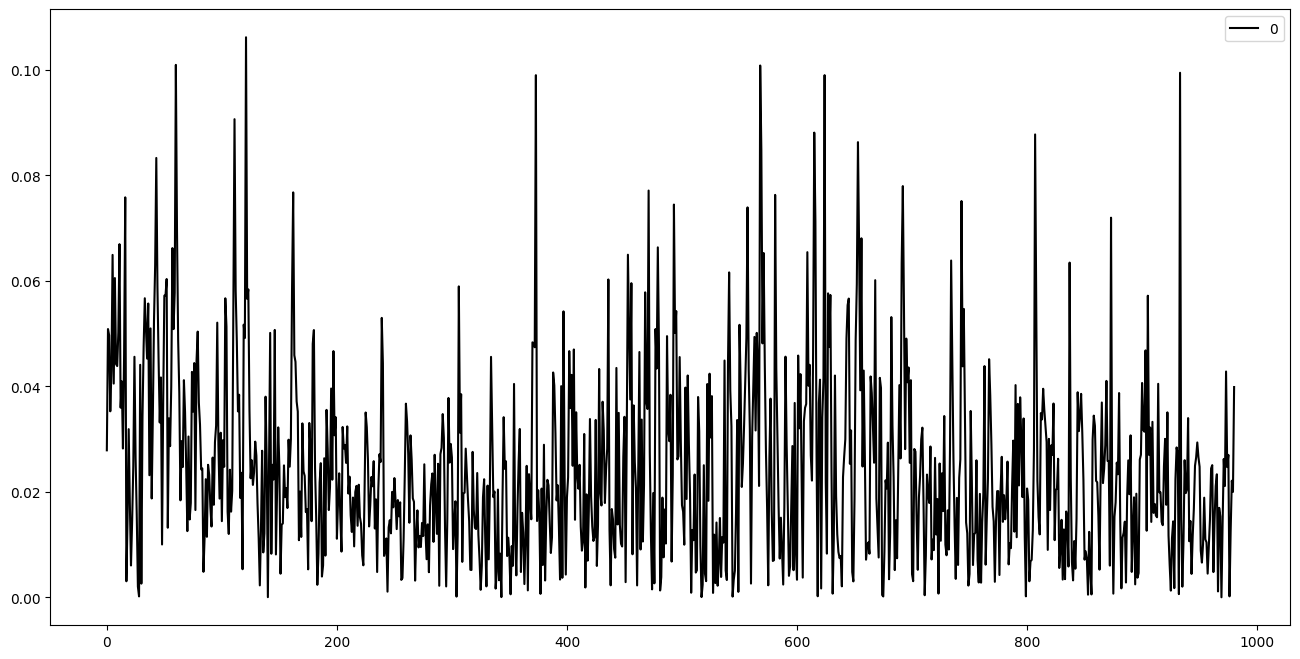

In [6]:
(np.abs(y_pred - Y_test)/Y_test).plot(figsize=(16,8),color = ('black','green'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

<Axes: >

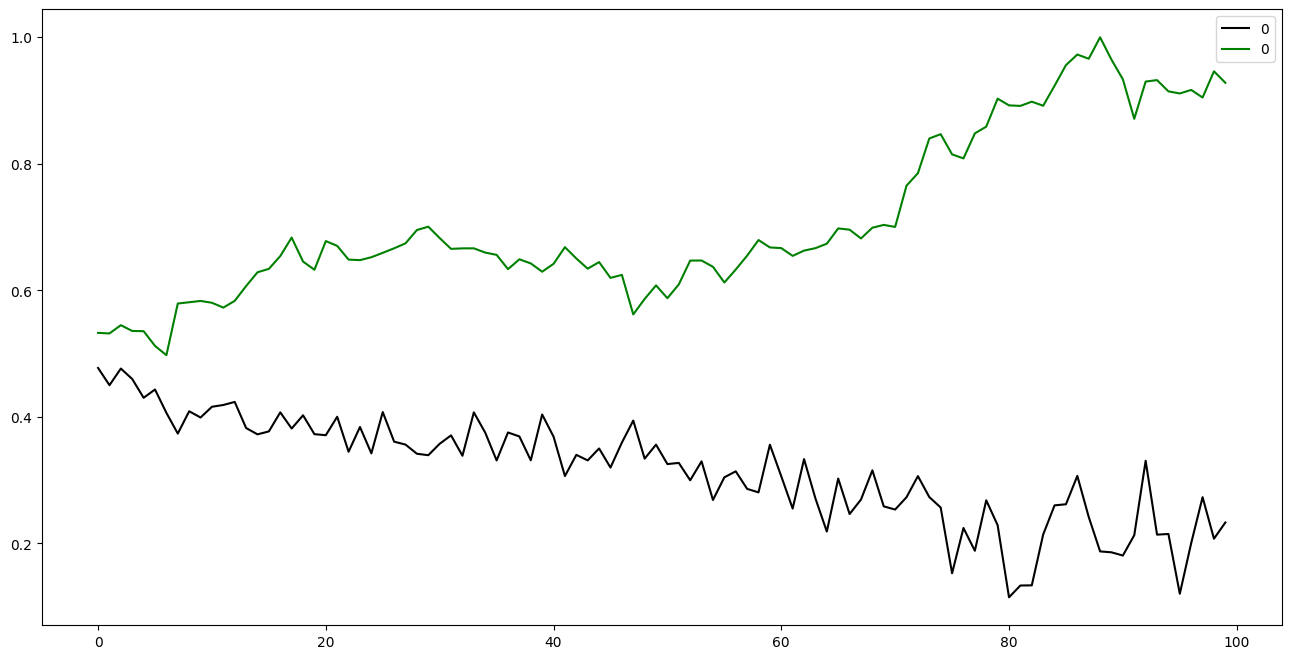

In [33]:
import random
def UserInput_Two(ticker='aapl',daysago=100,futureproj=100):
    Y_test = TickerIntoTensor(ticker,daysago,1,-futureproj)[3]
    X_test = TickerIntoTensor(ticker,daysago,1,-futureproj)[1]
    X_test = X_test[0].reshape((-1,daysago+1,1))
    y_pred_proj = []
    for i in range(1,futureproj+1):
        y_pred = model1.predict(X_test)
        #y_pred = y_pred * random.uniform((np.min(X_test)-y_pred)/np.min(X_test),(np.max(X_test)-y_pred)/np.max(X_test))
        y_pred = y_pred + (np.std(X_test) * random.normalvariate(0,0.5))
        y_pred_proj = np.append(y_pred_proj,y_pred)
        X_test = X_test.reshape((-1))
        X_test = np.append(X_test, y_pred)
        #X_test = X_test[1:]
        X_test = X_test.reshape((-1,daysago+1+i,1))
    return y_pred_proj,Y_test

e = UserInput_Two('nvda',100,100)
y_pred = pd.DataFrame(e[0])
Y_test = pd.DataFrame(e[1])
e = pd.concat([y_pred,Y_test],axis=1)
e.plot(figsize=(16,8),color = ('black','green'))